### What is **`superpixel_label`**?

In an image, instead of looking at each tiny pixel one by one, we can group nearby, similar pixels together. These groups are called **superpixels**.

* **`superpixel_label`** is just a number that tells us **which group** a certain set of pixels belongs to.
* So, `superpixel_label = 0` means group 0, `1` means group 1, and so on.

---

### Why do we use superpixels?

Imagine trying to understand a photo. Looking at every single pixel would take forever! So we:

* Group similar pixels together (superpixels),
* Give each group a label (a number),
* Then study each group instead of every pixel.

---

### What about the other columns?

Each row shows information about **one superpixel**:

* `mean_log_ratio`: some average value for that group,
* `diff_alpha1`: another feature (could be a difference between values),
* `median_slope`: maybe a measurement of how steep or angled the group is.

---

### Example:

| superpixel\_label | mean\_log\_ratio | diff\_alpha1 | median\_slope |
| ----------------- | ---------------- | ------------ | ------------- |
| 2                 | 0.43             | 5.08         | 1275.0        |

This means:

* Group #2 of pixels (superpixel 2)
* Has an average value of 0.43,
* A difference value of 5.08,
* And a slope (angle or steepness) of 1275.




# Purpose: 
- Preprocess and save the post-RTC image
- Partition the image into multiple segments and save the label as a np.array

In [1]:
import sys
from pathlib import Path

# Add the path to the utils folder to sys.path
utils_path = Path("/shared/Wildfire/Manuj_Code_Wildfire/uavsar-cads-main/python").resolve()
sys.path.append(str(utils_path))

import rasterio
import numpy as np
from pathlib import Path
from process_utils import (preprocess_data,
                           superpixel_segmentation)
from rio_utils import (reproject_arr_to_match_profile)
from edit_path_utils import (edit_paths)

---
## Load the images into arrays

**Parameter**:
- `tifs` (list): a list containing the paths to the images

In [2]:
# Opens a GeoTIFF and loads the backscatter values and profile
def open_one(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
        profile = ds.profile
    return band, profile

In [3]:
# Path to the folder with the cropped images
data_dir = Path("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_Hv_logration_Output/")
tifs = sorted(list(data_dir.glob('./*before_imputed_bobcat_hv*.tif')))

tifs

[PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_Hv_logration_Output/before_imputed_bobcat_hv_0.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_Hv_logration_Output/before_imputed_bobcat_hv_1.tif')]

---
Open the raster images and preprocess them.

Let `hv_0` and `profile_0` correspond to the pre-fire image, and `hv_1` and `profile_1` correspond to the post-fire image

In [4]:
# Open the tifs
bands, profiles = zip(*map(open_one, tifs))
hv_0 = bands[0]
hv_1 = bands[1]
profile_0 = profiles[0]
profile_1 = profiles[1]

---
## Preprocess the image
Applies interpolation, clipping, total-variation denoising, and background mask

**Parameters**
- `interpolation` (bool): whether or not to perform nearest neighbor interpolation for the preprocessing
- `weight` (float): denoising weight. The greater the weight, the more denoising (at the expense of fidelity to image). 

In [5]:
interpolation = True
weight = 5

In [6]:
hv_0 = preprocess_data(hv_0, interpolation, weight)
hv_1 = preprocess_data(hv_1, interpolation, weight)
print("Preprocessing done")

Preprocessing done


---
Reprojecting the array to match the profile of pre- and post- fire images, so arithmetic could be performed

In [7]:
# reproject the later flight to match the profile of the earlier flight
hv_1, _ = reproject_arr_to_match_profile(hv_1, profile_1, profile_0, resampling='bilinear')
hv_1 = hv_1[0]  # getting back to 2-D
print("Reproject done")

Reproject done


___
Saving the output to avoid long run-time in the future

**Parameters**
- `output_path_0` (str): output path for the processed pre-fire image [**.tif** file]
- `output_path_1` (str): output path for the processed post-fire image [**.tif** file]

In [8]:
output_path_0 = "/shared/Wildfire/Bety_wildfire_project/Bety_A_S_code/wildfire_HV_logratio/data_output_HV_logratio/before_imputed_hv_0_preprocessed_interpolated.tif"
output_path_1 = "/shared/Wildfire/Bety_wildfire_project/Bety_A_S_code/wildfire_HV_logratio/data_output_HV_logratio/before_imputed_hv_1_preprocessed_interpolated.tif"

In [9]:
with rasterio.open(output_path_0, "w", **profile_0) as dest:
    dest.write(hv_0, 1)
with rasterio.open(output_path_1, "w", **profile_0) as dest:
    dest.write(hv_1, 1)

___ 
## Superpixel Segmentation
Performs superpixel segmentation using [Felzenszwalb's algorithm](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.felzenszwalb) implemented by scikit-image to partition each image into multiple segments. The run time depends on the size of the images (~5-30mins)

**Parameters**
- `min_size` (int): minimum component size for Felzenszwalb's algorithm. Enforced using postprocessing. Check the hyperlink about scikit-learn implementation for more information
- `superpixel_out_path` (str): output path for the superpixel label as np.array. [**.npy**]

In [10]:
superpixel_labels = superpixel_segmentation(hv_0,hv_1, min_size=10000)
print("Superpixel done")
print(superpixel_labels)

Superpixel done
[[  0   0   0 ...  19  19  19]
 [  0   0   0 ...  19  19  19]
 [  0   0   0 ...  19  19  19]
 ...
 [468 468 468 ... 502 502 502]
 [468 468 468 ... 502 502 502]
 [468 468 468 ... 502 502 502]]


In [11]:
# superpixel_labels = superpixel_segmentation(hv_0, hv_1, min_size=100)
# print("Superpixel done")

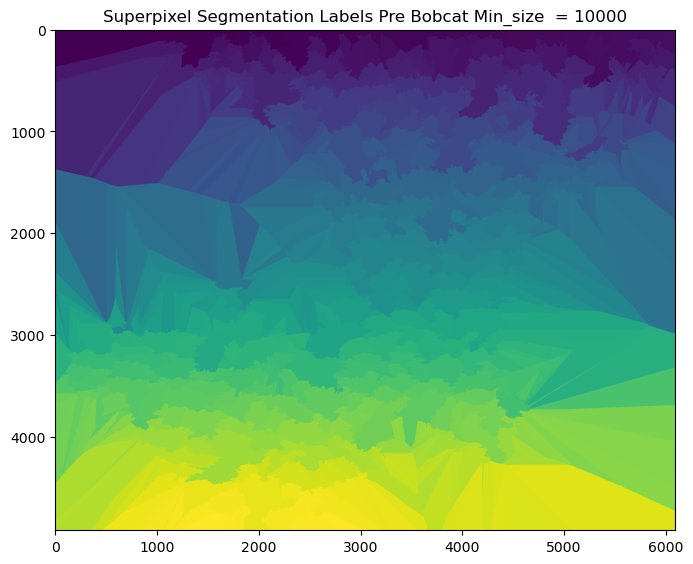

In [16]:
import matplotlib.pyplot as plt

# Assuming superpixel_labels is a 2D array (like from skimage.segmentation.slic or similar)
plt.figure(figsize=(8, 8))
plt.imshow(superpixel_labels)  # 'nipy_spectral' helps visualize different segments
plt.title('Superpixel Segmentation Labels Pre Bobcat Min_size  = 10000')
plt.show()


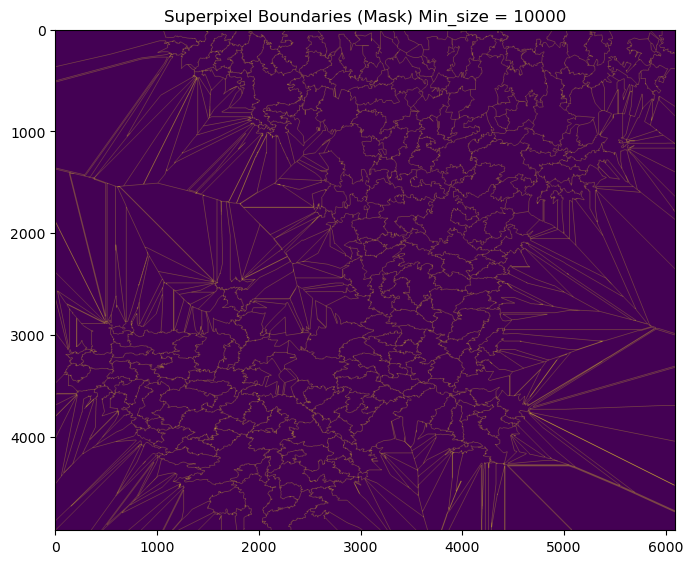

In [17]:
from skimage.segmentation import find_boundaries

# Create a binary boundary map
boundary_mask = find_boundaries(superpixel_labels)

plt.figure(figsize=(8, 8))
plt.imshow(boundary_mask)
plt.title('Superpixel Boundaries (Mask) Min_size = 10000')
plt.axis
plt.show()


In [18]:
superpixel_out_path = "/shared/Wildfire/Bety_wildfire_project/Bety_A_S_code/wildfire_HV_logratio/data_output_HV_logratio/superpixel_labels_230727_231017_min10000.npy"

In [19]:
np.save(superpixel_out_path, superpixel_labels)